In [ ]:
import numpy as np
import glob
import os

import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

import matplotlib.pyplot as plt

import segmentation_models as sm
sm.set_framework('tf.keras')

In [ ]:
data_folder = '/home/ubuntu/Desktop/VISUAL/PaintDetectionDataset'
train_path_images = os.path.join(data_folder, 'train/images')
train_path_masks = os.path.join(data_folder, 'train/masks')

test_path_images = os.path.join(data_folder, 'test/images')
test_path_masks = os.path.join(data_folder, 'test/masks')

In [ ]:
seed = 111
img_size = (224, 224)
batch_size = 8
epochs = 50
lr = 1e-4
BACKBONE = 'resnet34' #'vgg16'

preprocess_input = sm.get_preprocessing(BACKBONE)
datagen_args = dict(
    rotation_range=5,
    shear_range=10,
    zoom_range=[1, 1.2],
    vertical_flip=True,
    horizontal_flip=True
)

train_image_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    preprocessing_function=preprocess_input, 
    validation_split=0.2,
    **datagen_args,
)

train_mask_datagen = keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2,
    **datagen_args
)

image_generator = train_image_datagen.flow_from_directory(
    train_path_images, 
    class_mode=None, 
    seed=seed,
    target_size=img_size,
    batch_size=batch_size,
    subset='training'
)

mask_generator = train_mask_datagen.flow_from_directory(
    train_path_masks,
    class_mode=None, 
    color_mode='grayscale',
    seed=seed,
    target_size=img_size,
    batch_size=batch_size,
    subset='training'
)

train_generator = zip(image_generator, mask_generator)

In [ ]:
val_image_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    preprocessing_function=preprocess_input, 
    validation_split=0.2
)
val_mask_datagen = keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2
)

val_image_generator = val_image_datagen.flow_from_directory(
    train_path_images, 
    class_mode=None, 
    seed=seed,
    target_size=img_size,
    batch_size=batch_size,
    subset='validation'
)
val_mask_generator = val_mask_datagen.flow_from_directory(
    train_path_masks,
    class_mode=None, 
    color_mode='grayscale',
    seed=seed,
    target_size=img_size,
    batch_size=batch_size,
    subset='validation'
)

val_generator = zip(val_image_generator, val_mask_generator)

In [ ]:
fig, axs = plt.subplots(2, 12, figsize=(32, 4))
for i in range(12):
    x = next(train_generator)
    axs[0, i].imshow(x[0][0])
    axs[1, i].imshow(x[1][0])

In [ ]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

model = sm.Unet(BACKBONE, encoder_weights='imagenet', encoder_freeze=True)
model.summary()

In [ ]:
import math
def spe(y, batch_size):
    return int(math.ceil((1. * y) / batch_size))

In [68]:
model.compile(optimizer=tensorflow.keras.optimizers.Adam(lr), loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

callbacks = [
    keras.callbacks.ModelCheckpoint("painting_segmentation.h5", save_best_only=True)
]

history = model.fit(
    train_generator, 
    epochs=epochs, 
    steps_per_epoch=spe(200, batch_size), 
    validation_data=val_generator,
    validation_steps=spe(50, batch_size),
    callbacks=callbacks
)


Epoch 1/50


2022-02-06 00:28:31.753827: W tensorflow/core/framework/op_kernel.cc:1733] INVALID_ARGUMENT: ValueError: Could not find callback with key=pyfunc_14 in the registry.
Traceback (most recent call last):

  File "/home/ubuntu/Projects/music-classification/venv/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 263, in __call__
    raise ValueError(f"Could not find callback with key={token} in the "

ValueError: Could not find callback with key=pyfunc_14 in the registry.


2022-02-06 00:28:31.753869: W tensorflow/core/kernels/data/generator_dataset_op.cc:107] Error occurred when finalizing GeneratorDataset iterator: INVALID_ARGUMENT: ValueError: Could not find callback with key=pyfunc_14 in the registry.
Traceback (most recent call last):

  File "/home/ubuntu/Projects/music-classification/venv/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 263, in __call__
    raise ValueError(f"Could not find callback with key={token} in the "

ValueError: Could

25/25 [==============================] - ETA: 0s - loss: 1.4258 - iou_score: 0.2756

KeyboardInterrupt: 

In [ ]:
def plot_history(history, save=False, filepath=None):
    x_plot = list(range(1, len(history["loss"]) + 1))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.plot(x_plot, history["loss"])
    ax1.plot(x_plot, history["val_loss"])
    ax1.legend(["Training", "Validation"])

    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("IOU")
    ax2.plot(x_plot, history["iou_score"])
    ax2.plot(x_plot, history["val_iou_score"])
    ax2.legend(["Training", "Validation"], loc="lower right")

    fig.show()

    if save and filepath is not None:
        fig.savefig(filepath)

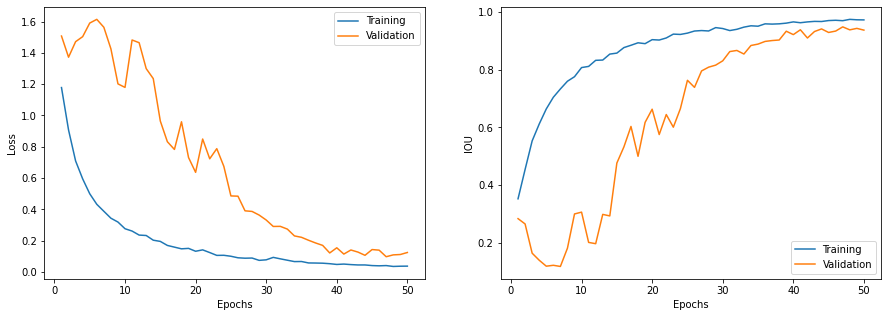

In [69]:
plot_history(history.history)

In [70]:
test_image_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input,)
test_mask_datagen = keras.preprocessing.image.ImageDataGenerator()

test_image_generator = test_image_datagen.flow_from_directory(
    test_path_images, 
    class_mode=None, 
    seed=42,
    target_size=img_size,
    batch_size=batch_size,
)
test_mask_generator = test_mask_datagen.flow_from_directory(
    test_path_masks,
    class_mode=None, 
    color_mode='grayscale',
    seed=42,
    target_size=img_size,
    batch_size=batch_size,
)

test_generator = zip(test_image_generator, test_mask_generator)
loss, iou_score = model.evaluate(test_generator, steps=spe(50, batch_size), batch_size=batch_size)

print('loss: {}, iou_score: {}'.format(loss, iou_score))

# resnet34
# train loss: 0.04106525331735611, iou_score: 0.9721957445144653
# val loss: 0.0969313457608223, iou_score: 0.9506393074989319
# test loss: 0.15183262526988983, iou_score: 0.9222055673599243

# resnet18
# train loss: 0.05787457153201103, iou_score: 0.9644907116889954
# val loss: 0.08626668155193329, iou_score: 0.9521622657775879
# test loss: 0.17578180134296417, iou_score: 0.915815532207489

Found 50 images belonging to 1 classes.
Found 50 images belonging to 1 classes.
7/7 [==============================] - 2s 312ms/step - loss: 1.7066 - iou_score: 0.4091
loss: 1.70656156539917, iou_score: 0.40905264019966125


In [ ]:
fig, axes = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(25, 8))

paths = glob.glob(os.path.join(test_path_images, 'img', '*.jpg'))

images = np.zeros((len(paths), 224, 224, 3))
for i, img_path in enumerate(paths):
    img = load_img(img_path, target_size=(224, 224))
    img = img_to_array(img) / 255.0
    img = preprocess_input(img)
    images[i] = img

preds = model.predict(images)

for i in range(len(paths)):
    mask = preds[i]
    mask = (mask >= 0.5).astype(np.uint8)

    k = i // 10
    j = i % 10

    axes[k, j].imshow(images[i])
    axes[k, j].imshow(mask, 'jet', interpolation='none', alpha=0.7)
    axes[k, j].axis('off')

fig.tight_layout()